# Demo

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax wandb chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [6]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial
import objax
import chex
from pprint import pprint

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.transforms.parametric.mixture import MixtureGaussianCDF
from rbig_jax.transforms.logit import Logit
from rbig_jax.transforms.inversecdf import InverseGaussCDF
from rbig_jax.transforms.parametric import HouseHolder
from rbig_jax.transforms.base import CompositeTransform
# from rbig_jax.models.gaussflow import GaussianizationFlow


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Demo Data

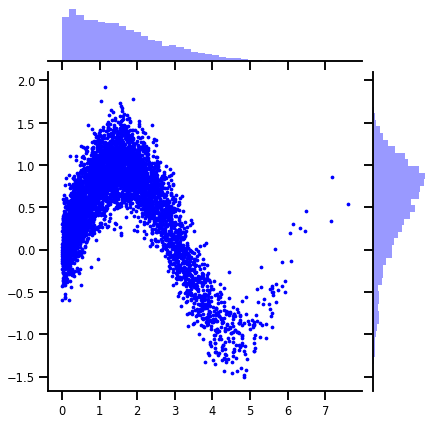

In [68]:
# %%wandb
# get data

n_samples = 5_000
n_features = 2


data = get_classic(n_samples)

# plot data
sns.jointplot(data[:, 0], data[:, 1], s=5, color='blue')

### Model

In [69]:
# model hyperparameters
n_components = 20
n_reflections = 2
n_features = data.shape[1]


n_layers = 4

transforms = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    transforms.append(
        MixtureGaussianCDF(n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    transforms.append(
        Logit()
    )
    # orthogonal rotation layer
    transforms.append(
        HouseHolder(n_reflections=n_reflections)
    )
    
# compose all transformations into a single chain
init_func = CompositeTransform(transforms)

# initialize base distribution
base_dist = jax.scipy.stats.norm

In [70]:
seed = 123
flow_rng = jax.random.PRNGKey(seed)

# initialize parameters, forward and inverse function
params, forward_transform, inverse_transform = init_func(flow_rng, n_features)

### Loss Function

In [71]:
def nll_loss(params, inputs):
    # forward transformation from chain
    z, logabsdet = forward_transform(params, inputs)
    
    # latent probability
    latent_prob = base_dist.logpdf(z)
    
    # log probability
    log_prob = latent_prob.sum(axis=1) + logabsdet
    
    # negative log-likelihood
    return - log_prob.mean()

In [72]:
nll_loss(params, data)

DeviceArray(55.76823, dtype=float32)

### Optimizer

In [73]:
from jax.experimental import optimizers

lr = 0.05
epochs = 100
batch_size = 128


opt_init, opt_update, get_params = optimizers.adam(step_size=lr)
opt_state = opt_init(params)

### Grad Step

In [74]:
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    loss, gradients = jax.value_and_grad(nll_loss)(params, inputs)
    return loss, opt_update(i, gradients, opt_state)

train_op = jax.jit(step)

### Optimization

In [75]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data)

losses = list()

pbar = tqdm.trange(epochs)

itercount = itertools.count()

with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss, opt_state = train_op(
                next(itercount), 
                opt_state,
                train_data[batch_index:batch_index+batch_size],
            )
            
            
            # append batch
            avg_loss.append(float(loss))
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 100/100 [00:39<00:00,  2.53it/s, loss=1.4919]


In [8]:
from typing import List

class GaussianizationFlow:
    def __init__(
        self, rng, n_features: int, bijections: List, base_dist: None, 
    ):
        # initialize bijections
        self.init_func = CompositeTransform(bijections)
        
        # create Gaussinization block
        
        self.n_features = n_features
        self.bijections = bijections
        
        # create base distribution
        if base_dist is None:
            base_dist = jax.scipy.stats.norm

        self.base_dist = base_dist
    
    def init_params(self, rng, n_features):
        
        params, forward_transform, inverse_transform = self.init_func(flow_rng, n_features)
        
        self.forward_chain = forward_transform
        self.inverse_chain = inverse_transform
        
        return params

    def __call__(self, params, X):
        return self.bijections(params, X)

    def transform(self, params, X):
        return self.forward_transform(params, X)

    def inverse_transform(self, params, X):
        return self.bijections.inverse(params, X)

    def log_det_jacobian(self, params, X):
        _, logabsdet = self.bijections(params, X)
        return logabsdet

    def score_samples(self, params, X):
        z, logabsdet = self.bijections(params, X)

        log_prob = self.base_dist.logpdf(z)

        return log_prob.sum(axis=1) + logabsdet

    def score(self, params, X):
        return -self.score_samples(params, X).mean()

#     def sample(self, n_samples: int):

#         X_gauss = objax.random.normal(
#             (n_samples, self.n_features), generator=self.generator
#         )
#         return self.inverse_transform(X_gauss)


In [41]:
# model hyperparameters
n_components = 20
n_reflections = 2
generator = objax.random.Generator(123)
learn_temperature = False
n_features = data.shape[1]


n_layers = 4

transforms = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    transforms.append(
        MixtureGaussianCDF(n_features=n_features, n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    transforms.append(
        Logit(learn_temperature=learn_temperature)
    )
    # orthogonal rotation layer
    transforms.append(
        HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator)
    )
    
# compose all transformations into a single chain
transform = CompositeTransform(transforms)

# initialize base distribution
base_dist = jax.scipy.stats.norm

# initialize Model
gf_model = GaussianizationFlow(n_features=n_features, bijections=transform, base_dist=base_dist)

In [42]:
pprint(len(gf_model.vars()))

25


#### Loss Function

In [43]:
# vectorized the model to allow for batches
# model_vectorized = objax.Vectorize(model, vc=model.vars())

# model_jitted = objax.Jit(model, vc=model.vars())


@objax.Function.with_vars(gf_model.vars())
def nll_loss(x):
    return gf_model.score(x)

In [44]:
nll_loss(data)

DeviceArray(44.37001, dtype=float32)

##### Optimizer

In [45]:
# define the optimizer
opt = objax.optimizer.Adam(gf_model.vars())

# get grad values
gv = objax.GradValues(nll_loss, gf_model.vars())
lr = 0.05
epochs = 100
batch_size = 128

@objax.Function.with_vars(gf_model.vars() + opt.vars())
def train_op(x):
    g, v = gv(x)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op)

#### Testing

In [46]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data)

losses = list()

pbar = tqdm.trange(epochs)

with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss = float(train_op( train_data[batch_index:batch_index+batch_size])[0])
            # append batch
            avg_loss.append(loss)
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 100/100 [00:33<00:00,  2.94it/s, loss=1.4586]


#### Losses

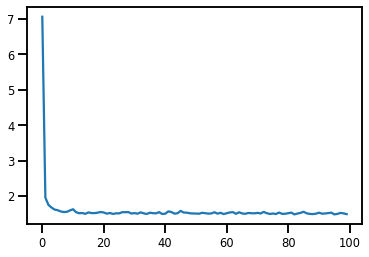

In [76]:
plt.plot(losses)

In [77]:
final_params = get_params(opt_state)

#### Forward Transformation

In [78]:
%%time
# forward transformation
z, _ = forward_transform(final_params, data)

CPU times: user 967 ms, sys: 61.8 ms, total: 1.03 s
Wall time: 683 ms


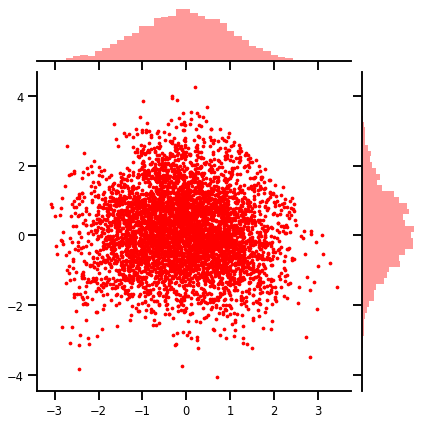

In [79]:
sns.jointplot(z[:, 0], z[:, 1], s=5, color='red')

#### Inverse Transformation

In [80]:
%%time
# inverse transformation
inverse_transform_jitted = jax.jit(inverse_transform)
X_approx , _ = inverse_transform_jitted(final_params, z)

CPU times: user 6.35 s, sys: 0 ns, total: 6.35 s
Wall time: 6.34 s


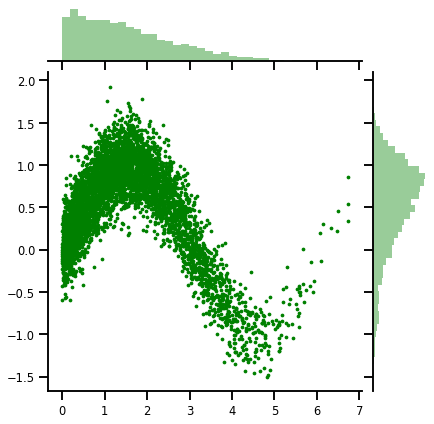

In [81]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='green')

### Application I - Generating Samples

In [82]:
%%time
# generate samples in the latent domain
n_gen_samples = 10_000

z_samples = jax.random.normal(rng, shape=(n_gen_samples, 2))

# inverse transformation
X_samples , _ = inverse_transform_jitted(final_params, z_samples)

CPU times: user 6.23 s, sys: 12.9 ms, total: 6.24 s
Wall time: 6.23 s


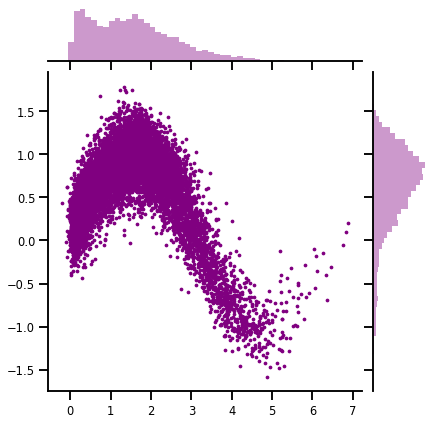

In [83]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='purple')

### Probability Density Estimation

In [84]:
%%time
# log probability
# X_log_prob = gf_model.score_samples(np.array(data))

# forward transformation
z, logabsdet = forward_transform(final_params, data)

# latent probability
latent_prob = base_dist.logpdf(z)

# log probability
X_log_prob = latent_prob.sum(axis=1) + logabsdet

CPU times: user 736 ms, sys: 49.9 ms, total: 786 ms
Wall time: 470 ms


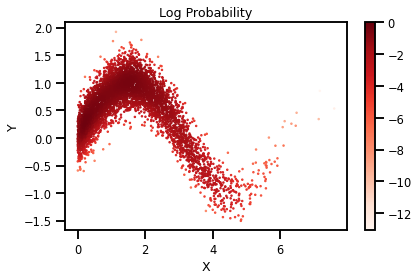

In [85]:
cmap = "Reds"
probs = X_log_prob
# probs = np.clip(probs, 0.0, 1.0)
probs = np.clip(probs, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap, vmax=0.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Probability

In [86]:
ngrid = 1_000
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [87]:
%%time
# log probability
# log_prob = gf_model.score_samples(np.array(xyinput))
# forward transformation
z, logabsdet = forward_transform(final_params, np.array(xyinput))

# latent probability
latent_prob = base_dist.logpdf(z)

# log probability
X_log_prob = latent_prob.sum(axis=1) + logabsdet

CPU times: user 32.7 s, sys: 11.9 s, total: 44.7 s
Wall time: 6.24 s


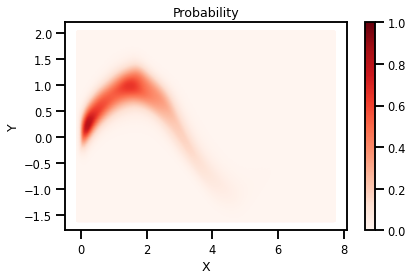

In [88]:
cmap = "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Negative Log-Likelihood

In [89]:
nll = nll_loss(final_params, data)

print("Negative Log-Likelihood:", nll)

Negative Log-Likelihood: 1.5056756
